In [269]:
%reload_ext autoreload
%autoreload 2

## Imports

In [37]:
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from functools import partial

from core_vectorized import UnconditionalNF, ConditionalNF

## Energy function with argument

In [316]:
def U1_with_argument(z, angle, distance):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2) + 
        1e-5
    )
    return (term1 - term2)

In [317]:
U = partial(U1_with_argument, angle=np.pi/4, distance=2)

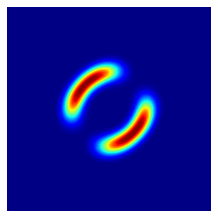

In [318]:
fig = plt.figure(figsize=(3.75, 3.75))

xs = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, xs)
xxs2, yys2 = xxs.reshape(-1, 1), yys.reshape(-1, 1)
unnorm_p = torch.exp(- U(torch.hstack([xxs2, yys2])))

plt.contourf(xxs.numpy(), yys.numpy(), unnorm_p.reshape(100, 100).numpy(), levels=100, cmap="jet")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
#plt.savefig(f"imgs/{potential}_true_density.png", dpi=300, bbox_inches='tight')

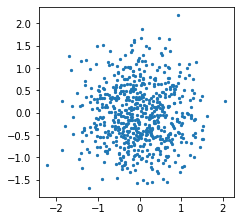

In [319]:
# testing
q_z_given_x = ConditionalNF(x_dim=784, D=2, L=100)
z_samples, log_probs = q_z_given_x.rsample(x=torch.zeros(64, 784), num_samples_per_x=10)
z_samples.shape, log_probs.shape

plt.figure(figsize=(3.5, 3.5))
z_samples_np = z_samples.reshape(640, 2).detach().numpy()
plt.scatter(z_samples_np[:, 0], z_samples_np[:, 1], s=5)
plt.show()

In [320]:
def U1_with_argument(z, angle, distance=3):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2) + 
        1e-5
    )
    return (term1 - term2)

def U_eight(z, divider=1):
    return U_with_argument(z, torch.pi/4, 3) + \
           U_with_argument(z, torch.pi / 2 + torch.pi/4, 3) + \
           U_with_argument(z, 0, 3) + \
           U_with_argument(z, torch.pi / 2, 3)


In [321]:
len(torch.randn(100).shape)

1

## Energy function with argument (vectorized)

In [322]:
def vec_U1_with_argument(zs, angles, distance=2):
    """
    angles: (bs, )
    zs: (bs, num_samples, 2)
    """
    
    assert len(angles.shape) == 1, "Angles must be one-dimensional. (Two-dimensional causes unwanted broadcasting.)"
    
    a = torch.cos(angles)
    b = -torch.sin(angles)
    c = torch.sin(angles)
    d = torch.cos(angles)
    
    rotation_mats = torch.vstack([a, b, c, d]).T.reshape(-1, 2, 2)  # (bs, 2, 2)
    
    # rotation_mats bmm zs.T: (bs, 2, 2) bmm (bs, 2, num_samples) => (bs, 2, num_samples)
    # tranpose 1 and 2: (bs, 2, num_samples) => (bs, num_samples, 2)
    
    zs = torch.bmm(rotation_mats, zs.transpose(1, 2)).transpose(1, 2)
    
    term1 = 0.5 * ((torch.sqrt(zs[:, :, 0] ** 2 + zs[:, :, 1] ** 2) - distance) / 0.4) ** 2
    term2 = torch.log(
        torch.exp(-0.5 * ((zs[:, :, 0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((zs[:, :, 0] + distance) / 0.6) ** 2) + 
        1e-6
    )
    return (term1 - term2)

In [311]:
zs = (torch.rand(10, 10000, 2) - 0.5) * 12
temp = torch.exp(- vec_U1_with_argument(zs, torch.linspace(start=0, end=np.pi/2, steps=10)))

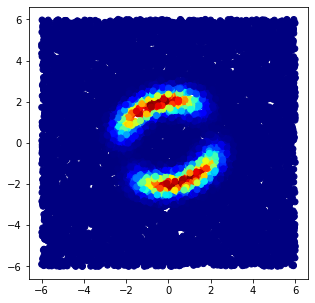

In [323]:
plt.figure(figsize=(5, 5))
i = 7
plt.scatter(zs[i][:, 0], zs[i][:, 1], c=temp[i], cmap="jet")
plt.show()

## Unconditional NF training

In [390]:
q = UnconditionalNF(D=2, L=16)
opt = optim.Adam(q.parameters(), lr=1e-2)

sample_kls = []

for i in range(1, 1001):

    q_samples, log_probs = q.rsample(num_samples=1000)
    sample_kl = (log_probs + vec_U1_with_argument(q_samples.unsqueeze(0), torch.tensor([0.]))[0]).mean()
    sample_kls.append(float(sample_kl))

    opt.zero_grad()
    sample_kl.backward()
    opt.step()

    if i % 100 == 0:

        print(i, float(sample_kl))

100 -1.6508674621582031
200 -1.7914623022079468
300 -1.716593623161316
400 -1.836230754852295
500 -1.8185153007507324
600 -1.8454097509384155
700 -1.8403911590576172
800 -1.861106514930725
900 -1.8547230958938599
1000 -1.857035756111145
1100 -1.8626660108566284
1200 -1.8701101541519165
1300 -1.8669601678848267
1400 -1.8638200759887695
1500 -1.861158013343811
1600 -1.8599357604980469
1700 -1.8748828172683716
1800 -1.846408724784851
1900 -1.844547152519226
2000 -1.865630865097046
2100 -1.8663913011550903
2200 -1.860798954963684
2300 -1.8061623573303223
2400 -1.8401919603347778


KeyboardInterrupt: 

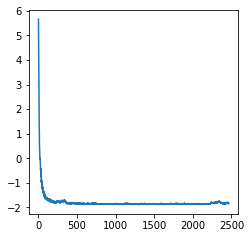

In [391]:
fig = plt.figure(figsize=(3.75, 3.75))
plt.plot(sample_kls)
plt.show()

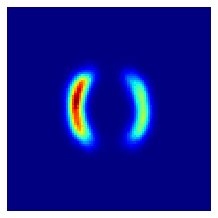

In [393]:
fig = plt.figure(figsize=(3.75, 3.75))

with torch.no_grad():
    q_samples, _ = q.rsample(num_samples=int(1e6))
    q_samples = q_samples.numpy()

plt.hist2d(q_samples[:,0], q_samples[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])
    
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

## Conditional NF training

In [513]:
q = ConditionalNF(D=2, L=32, x_dim=1)
print("Output dim of amortizer", q.amortizer_output_dim)
opt = optim.Adam(q.parameters(), lr=3e-5)
num_samples_per_x = 100

sample_kls = []

for i in range(1, 10001):
    
    if i == 5001:
        print("Final phase of training with a small learning rate and less gradient variance...")
        opt = optim.Adam(q.parameters(), lr=1e-5)
        num_samples_per_x = 1000

    xs = (torch.rand(32) - 0.5) * (2 * torch.pi)  # [-pi, pi]

    q_samples, log_probs = q.rsample(xs.reshape(-1, 1), num_samples_per_x=num_samples_per_x)

    sample_kl = (log_probs + vec_U1_with_argument(q_samples, xs)).mean()
    
    sample_kls.append(float(sample_kl))

    opt.zero_grad()
    sample_kl.backward()
    opt.step()

    if i % 100 == 0:

        print(i, np.mean(sample_kls[-20:]))

Output dim of amortizer 164
100 -0.3732404425740242
200 -1.220691043138504
300 -1.40238356590271
400 -1.4292251646518708


KeyboardInterrupt: 

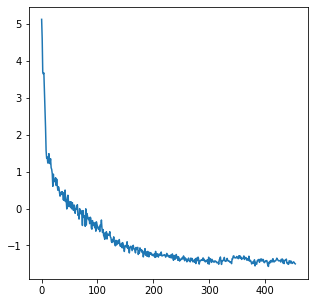

In [514]:
fig = plt.figure(figsize=(5, 5))
plt.plot(sample_kls)
plt.show()

## Visualization

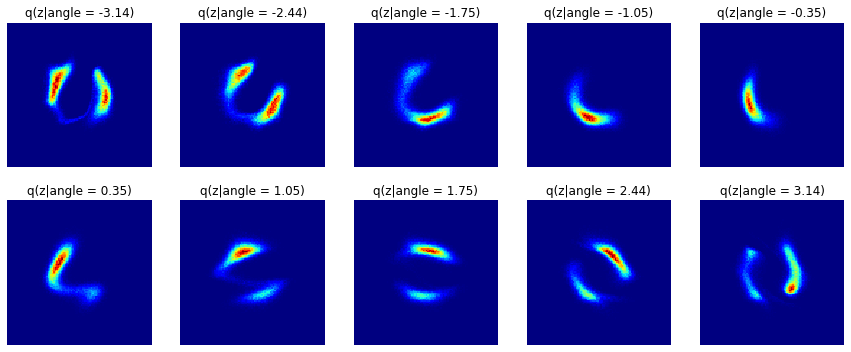

In [515]:
angle_torch = torch.linspace(-torch.pi, torch.pi, 10)

with torch.no_grad():
    q_samples, _ = q.rsample(angle_torch.reshape(-1, 1), num_samples_per_x=int(1e5))
    q_samples = q_samples.numpy()
    
f, subplots = plt.subplots(figsize=(15, 6), nrows=2, ncols=5)
    
for i in range(2):
    
    for j in range(5):
    
        ax = subplots[i][j]

        ax.hist2d(q_samples[i*5+j, :,0], q_samples[i*5+j, :,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])

        ax.axis("off")
        ax.set_aspect('equal', adjustable='box')
        
        ax.set_title(f"q(z|angle = {round(float(angle_torch[i*5+j]), 2)})")

plt.show()

In [512]:
def f(angle):
    
    fig = plt.figure(figsize=(3.75*3, 3.75))
    
    fig.add_subplot(131)
    
    plt.scatter([angle], [0], color="black", s=20)
    
    plt.xlim(-np.pi - 0.2, np.pi + 0.2)
    plt.xlabel("Angle")  
    plt.xticks([-3.14, 0, 3.14])
    plt.ylim(-0.1, 0.1)
    plt.yticks([])
    
    fig.add_subplot(132)
    
    xs = torch.linspace(-6, 6, 100)
    xxs, yys = torch.meshgrid(xs, xs)
    xxs2, yys2 = xxs.reshape(-1, 1), yys.reshape(-1, 1)
    unnorm_p = vec_U1_with_argument(torch.hstack([xxs2, yys2]).unsqueeze(0), torch.tensor([float(angle)]))
    
    plt.contourf(xxs.numpy(), yys.numpy(), torch.exp(-unnorm_p).reshape(100, 100).numpy(), levels=100, cmap="jet")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.axis("off")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("p(z|angle) (unnormalized)")
    
    fig.add_subplot(133)
    
    angle_torch = torch.tensor([float(angle)])

    with torch.no_grad():
        q_samples, _ = q.rsample(angle_torch.reshape(-1, 1), num_samples_per_x=int(1e6))
        q_samples = q_samples[0].numpy()

    plt.hist2d(q_samples[:,0], q_samples[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])

    plt.axis("off")
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.title("q(z|angle) (empirical)")

    return fig

In [327]:
import string
alphabet_string = string.ascii_lowercase
alphabet_list = list(alphabet_string)
print(alphabet_list)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u


/var/folders/3p/nlw2tdvn1jjg8pmw13cy2j5r0000gn/T/ipykernel_40583/1013021453.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(3.75*3, 3.75))


v
w
x
y
z


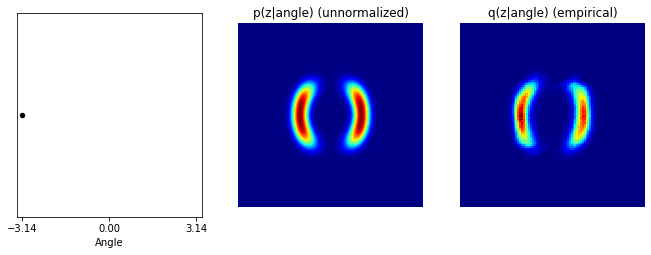

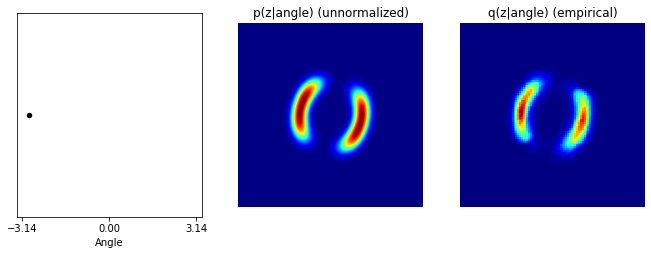

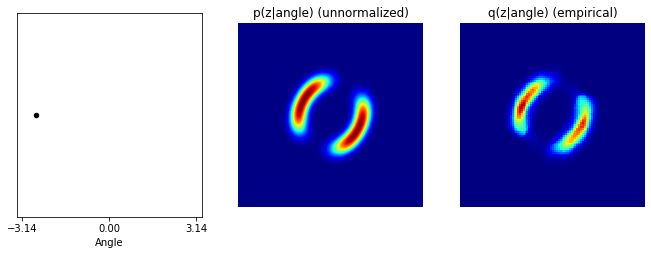

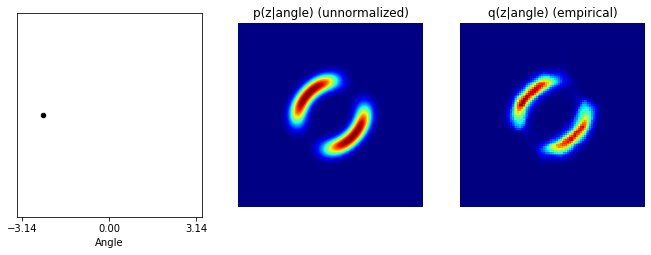

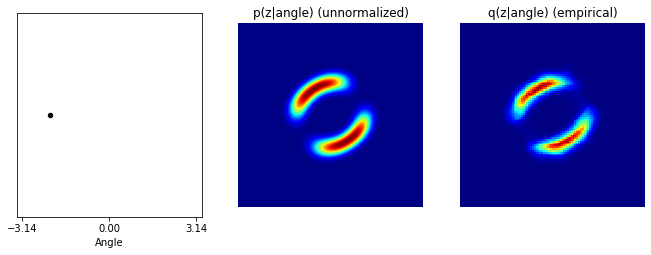

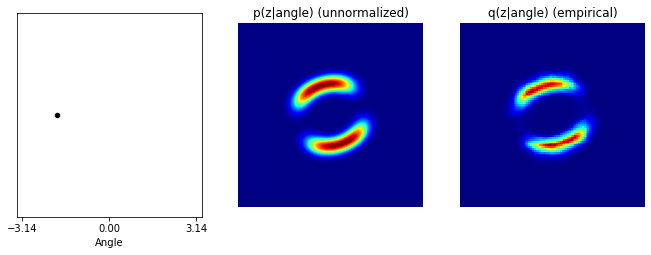

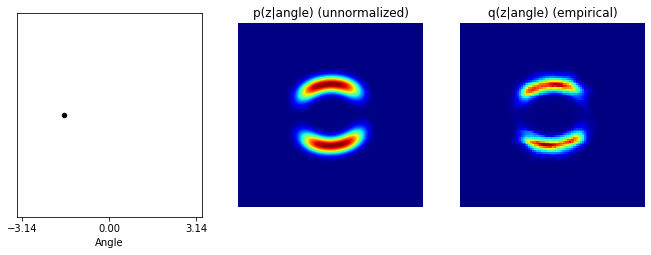

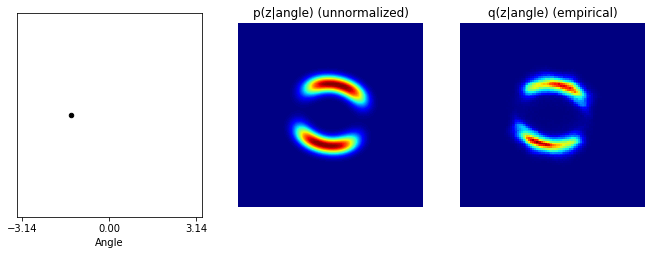

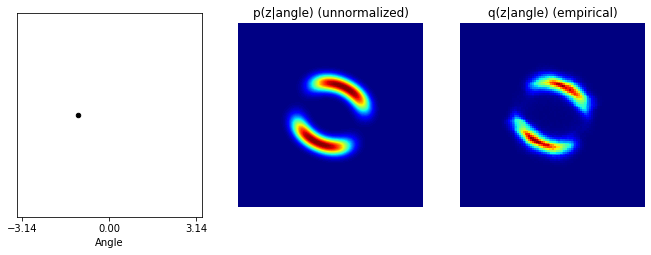

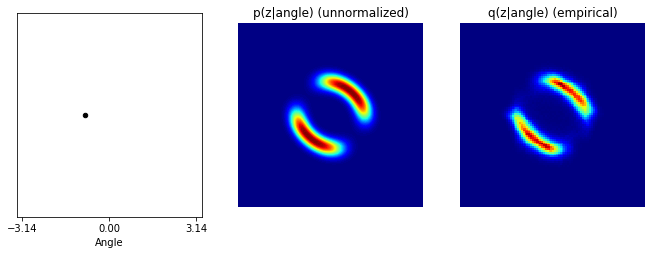

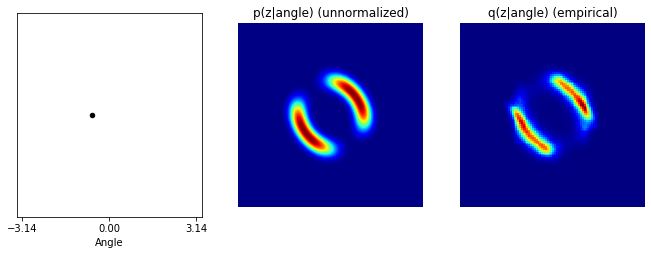

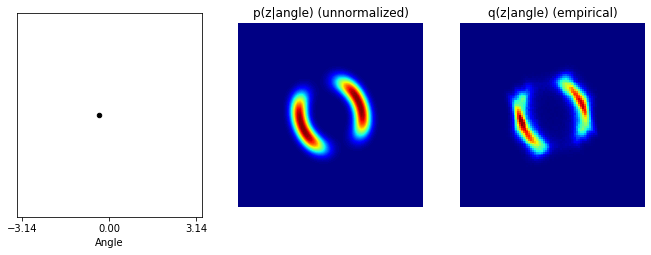

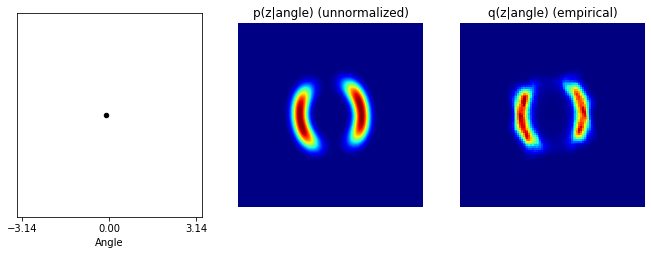

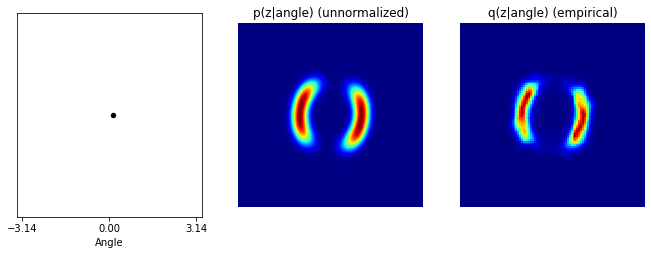

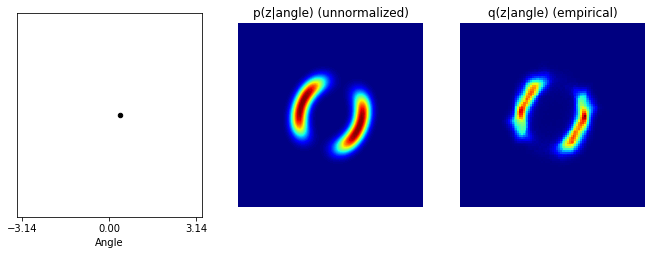

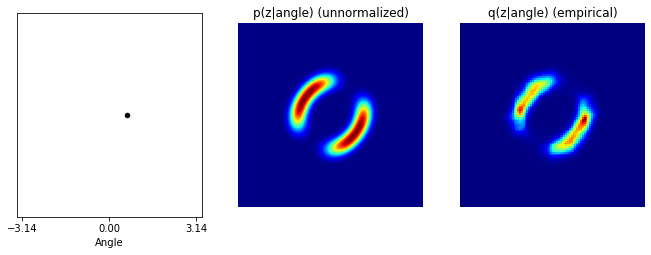

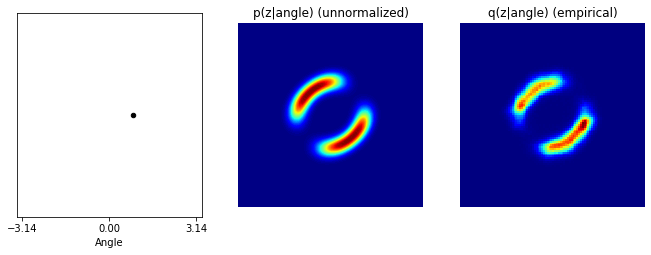

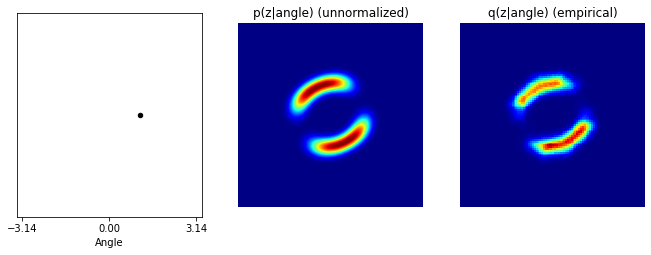

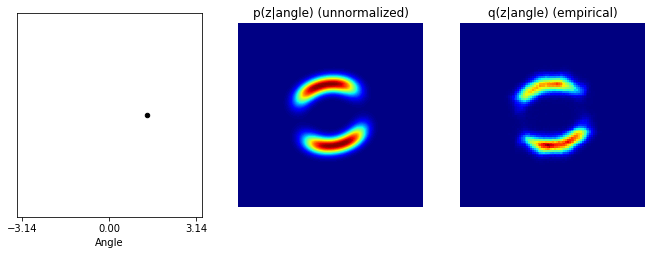

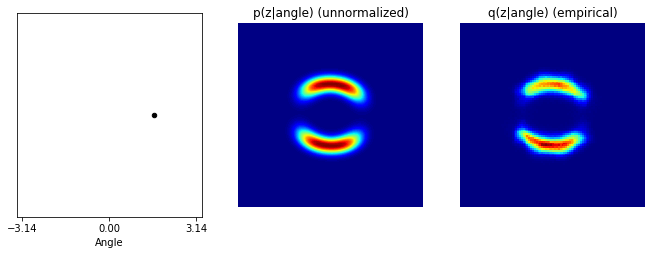

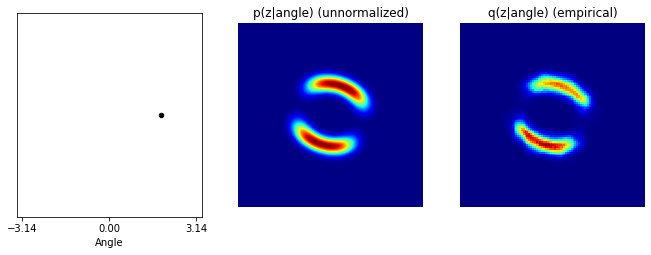

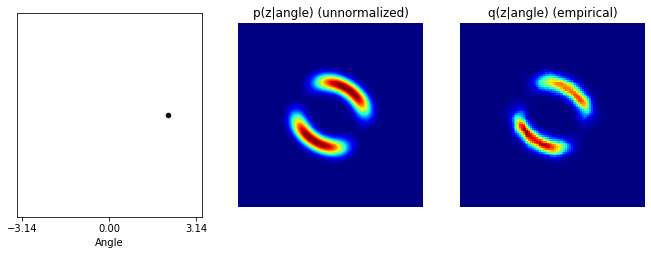

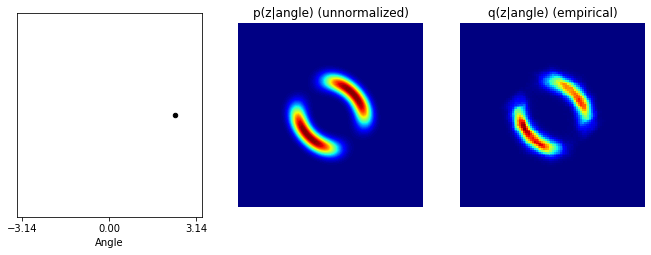

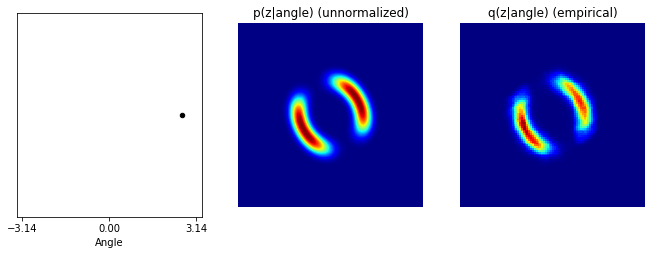

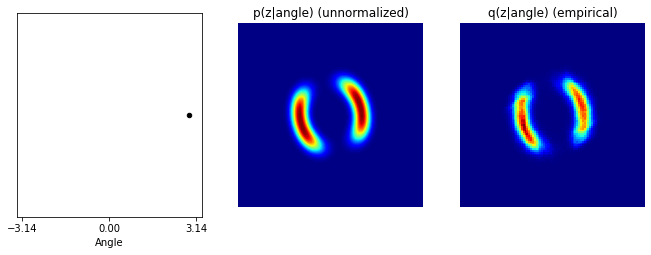

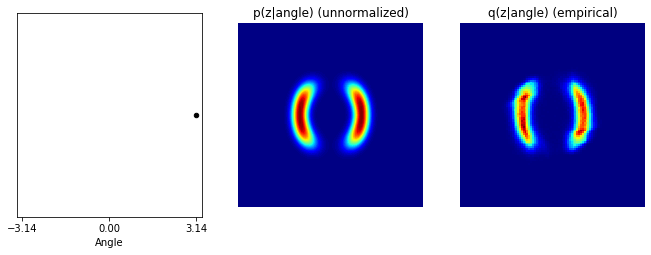

In [268]:
for alphabet, angle in zip(alphabet_list, np.linspace(-np.pi, np.pi, 26)):
    fig = f(angle)
    plt.savefig(f"imgs/conditional_vi/{alphabet}.png", dpi=300, bbox_inches='tight')

In [310]:
# fig = plt.figure(figsize=(3.75, 3.75))

# xs = torch.tensor([1.])

# with torch.no_grad():
#     q_samples, _ = q.rsample(xs.reshape(-1, 1), num_samples_per_x=int(1e6))
#     q_samples = q_samples[0].numpy()

# plt.hist2d(q_samples[:,0], q_samples[:,1], bins=100, cmap="turbo", range=[[-6, 6], [-6, 6]])
    
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')

# plt.show()